In [193]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

import os

from datetime import date

pd.options.display.max_colwidth = 400 #we used this in the NLP EDA Lab 5.02 and it I thought it makes sense to use it here, too.

In [194]:
df = pd.read_csv('data/data2022-06-26.csv')

In [195]:
back_up = df.copy()

In [196]:
df.head(1)

,created_utc,selftext,subreddit,title
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?


In [197]:
df.dtypes

created_utc     int64
selftext       object
subreddit      object
title          object
dtype: object

In [198]:
df.isnull().sum()

created_utc       0
selftext       2359
subreddit         0
title             0
dtype: int64

I'm opting to fill the nulls with '' because I want to explore posts that just consist of the title, which seems to be a fairly common way to use these subreddits.

In [199]:
df['selftext'] = df['selftext'].fillna('')
df.isnull().sum()

created_utc    0
selftext       0
subreddit      0
title          0
dtype: int64

I referenced the NLP EDA Lab 5.02 for this code to add column and word counts

In [200]:
df['submission_length'] = 0
df['submission_word_count'] = 0
df['title_length'] = 0
df['title_word_count'] = 0
for i in range(len(df)):
    df.loc[i, 'submission_length'] = len(df.loc[i, 'selftext'])
for i in range(len(df)):
    df.loc[i, 'title_length'] = len(df.loc[i, 'title'])
for i in range(len(df)):
    df.loc[i, 'submission_word_count'] = len(df.loc[i,'selftext'].split())
for i in range(len(df)):
    df.loc[i, 'title_word_count'] = len(df.loc[i,'title'].split())
    
df.head()

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
0,1656261965,[removed],startrek,Which version of Klingons will appear in SNW?,9,1,45,8
1,1656254308,[removed],startrek,On the Gorn and language,9,1,24,5
2,1656248567,[removed],startrek,What are some good things that can be said about Star Trek V?,9,1,61,13
3,1656238740,[removed],startrek,A Lord of the Rings reference in SNW 1x08,9,1,41,9
4,1656238132,[removed],startrek,The sword props used in SNW 1x08 are replicas of Aragorn's sword from 'The Fellowship of the Ring' and 'The Two Towers',9,1,119,22


In [201]:
df['subreddit'] = df['subreddit'].str.lower()
df[df['subreddit'] != 'startrek'].head(3)

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
3537,1656263202,[removed],starwars,"I know (almost) nothing about Star Wars, ask me anything",9,1,56,10
3538,1656263028,[removed],starwars,My Star Wars writing debut,9,1,26,5
3539,1656258044,[removed],starwars,I wrote a story!,9,1,16,4


In [202]:
# an optional backup. Ultimately, I opted not to use it.
# df.to_csv('data/cleaned_with_removed_posts.csv')

# `'[removed]'`

'[removed]' interferes with my "submission_length" and "submission_word_count" analyses, so I explore that here before removing those rows.

IMPORTANT NOTE ON METHODOLOGY: It's possible that some portion of the removed posts were removed because they were duplicates of other posts. [The rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules) are explicit that you cannot repost material. However, as I'm exploring the language used in these posts, I opted to remove the repeat titles. Admittedly, that means that some of the titles that are analyzed may point towards posts that were removed for repetition, *not* for the content itself, but that's a possibility I decided is preferable to overcounting the words in the repeated titles. On the day that I drew my data, there were 53 repeated Star Trek titles and 83 repeated Star Wars titles. These represent a relatively small number of data points.

## Rates of Removal

Observations:

There are 3584 Star Trek posts in the data set, of which 39.29% are "[removed]"
There are 3490 Star Wars posts in the data set, of which 16.48% are "[removed]"
Star Trek posts are removed at a higher rate.

![Removal Rates Bar Chart](images/removal_rates.png "removal rates for 'startrek' and 'StarWars' subreddits")

NOTE: I referenced [this site](https://www.digitalocean.com/community/tutorials/markdown-markdown-images) and [this site](https://marinegeo.github.io/2018-08-10-adding-images-markdown/) to learn how to add images to markdown files.

**I believe, instead, that the discrepancy in rates of removal results from differences in the two subreddits rules.**

I checked [the rules for the startrek subreddit](https://www.reddit.com/r/startrek/wiki/guidelines) and [the rules for the StarWars subreddit](https://www.reddit.com/r/StarWars/wiki/rules). Interestingly, the Star Wars rules were harder to find while the Star Trek ones were posted at the top of the page.

Subjectively, the Star Trek rules seem more attuned to interpersonal relationships (the first four are 'Be constructive', 'Be welcoming', 'Be honest', and 'Be nice'). None of the overall Star Wars rules speak about interpersonal behavior, though within the rules about 'comments' there is a rule about respecting fellow redditors, which links to [this page](https://www.reddit.com/r/StarWars/comments/cq4yv9/respecting_fellow_redditors_civility_bans_and_you/). This suggests that whether or not Star Trek fans are more likely to go after a show they don't like or break rules than Star Wars fans are, the moderation rules/moderators of the 'startrek' subreddit go further in enforcing some norms than those of the 'StarWars' subreddit.

## Word Usage in Removed Post Titles Compared with Word Usage in Non-Removed Post Titles

To examine the most frequently appearing words in the titles of these posts, I vectorized them. I tried to remove only value neutral words. For example, the English stopwords list includes 'not', and it seemed plausible that negative posts may be more likely to be removed, so I wanted to be able to examine those words.

I then compared the most frequently appearing words that appeared in the removed posts to those in all of the posts to see if there were any words that appeared in the former, but not in the latter:

|List|Words That Appear In All 'Removed' List But Not In 'Not Removed' List, Neutral Stopwords|
|---|---|
|Top 10| `'picard'`|
|Top 25| `'snw', 'so', 'spoilers'`|
|Top 50| `'question', 'watch', 'tng', 'time', 'enterprise', 'should', 'some', 'want', 'discovery'`|

|List|Words That Appear In Star Trek 'Removed' List But Not In 'Not Removed' List, Neutral Stopwords|
|---|---|
|Top 10| `<NO WORDs>`|
|Top 25| `'has', 'time', 'can'`|
|Top 50| `'anyone', 'some', 'love', 'had', 'ever'`|

|List|Words That Appear In Star Wars 'Removed' List But Not In All Posts List, Neutral Stopwords|
|---|---|
|Top 10| `'series', 'spoilers'`|
|Top 25| `'spoilers', 'should', 'show', 'finale', 'watch', 'but'`|
|Top 50| `'should', 'watch', 'order', 'question', 'reva', 'ep', 'want', 'best', 'season', 'sith', 'never', 'no'`|

The only 'negative' word that appeared is 'no', the last word in the Star Wars 'Removed' versus 'Not Removed' top 50 list.

I found the appearance of Star Trek titles ("Picard", "Enterprise", and "Discovery"), potentially interesting. Were Star Trek fans flaming these shows and getting removed for doing so in a way that was in violation of the subreddit's moderator policies? Instead, it appears that this was simply a product of the higher rate at which Star Trek shows are removed. No titles appear in the Star Trek exclusive comparisons.

The Star Wars discrepancies were a little more interesting:

Firstly, the appearance of 'spoilers' among the words appearing more frequently in removed posts than all posts at both the Top 10 and Top 25 level suggests that posting about "spoilers" leads to more frequent removal. It's also interesting that [Reva](https://starwars.fandom.com/wiki/Reva), a specific character appears in these lists,  as does ['Sith'](https://starwars.fandom.com/wiki/Sith?so=search), a group of characters, whereas there are no characters in the Star Trek list. This *might* suggest that Star Wars fans are more likely to discuss specific characters in a way that gets them removed. That said, these are both references that are relevant to a new show (['Obi-Wan Kenobi'](https://en.wikipedia.org/wiki/Obi-Wan_Kenobi_(TV_series), with Reva being a character on the show, it seems plausible that they're simply being discussed more frequently in posts that include spoilers and are being removed for their spoilers, not because of inflammatory discussion of characters.

I wanted to see what happened when I used the 'english' stopwords list. The results here provided more interesting details.

|List|Words That Appear In All 'Removed' List But Not In 'Not Removed' List, 'english' Stopwords|
|---|---|
|Top 10| `'strange', 'worlds'`|
|Top 25| `'question', 'watch', 'tng', 'time', 'enterprise'`|
|Top 50| `'want', 'character', 'ds9', 'voyager', 'tos', 'order', 'st', 'borg', 'thoughts', 'help', 'episodes', 'make'`|

|List|Words That Appear In Star Trek 'Removed' List But Not In 'Not Removed' List, 'english' Stopwords|
|---|---|
|Top 10| `<NO WORDs>`|
|Top 25| `'question', 'voyager', 'watch'`|
|Top 50| `'character', 'want', 'good', 'characters', 'favorite', 'people', 'crew', 'help', 'timeline', 'make', 'better', 'future', 'canon'`|

|List|Words That Appear In Star Wars 'Removed' List But Not In 'Not Removed' Posts List, 'english' Stopwords|
|---|---|
|Top 10| `'series', 'spoilers'`|
|Top 25| `'watch', 'order', 'question', 'reva', 'ep', 'want'`|
|Top 50| `'ep', 'want', 'sith', 'hate', 'starwars', 'thoughts', 'didn', 'start', 'fan', 'seen', 'discussion'`|

There seem to be similar patterns in the appearance of Star Trek proper names in the 'All Removed Posts' lists, appearing to correlate to the higher rate of removal on /r/startrek. 

As a Star Trek fan, it's interesting to see the appearance of 'canon' in the removed posts within the Star Trek analysis. Recent shows have, in the minds of many fans, deviated from 'canon', and some fans have been quite upset by it. It seems plausible that posts about 'canon' may be complaints about violations of 'canon' that have crossed a line into violations of the moderation policies. I find the top 50 word list as awhole very interesting: this is admittedly subjective, but the words seem to reflect poster's desires and a lot of discussion of characters/people. The order of the list in two cases, 'want' 'good' 'characters' and 'make' 'better' is perhaps ironic. Could it be that people are reflecting these desires in ways that are violating the rules for the subreddit?

The Star Wars words are also similar, though it's interesting to see the word 'hate' in particular showing up. Otherwise, similar patterns of words that seem plausibly related to spoilers appear.

The most notable two words in the set are 'ep' and 'want'. They are the only words that appear in successive lists across the whole analysis of these words: in other words, every other word that's in, for example, the top 25 list in any other set must appear in the top 50 of the non-removed posts, thus pushing it out of the discrepancy list when looking at all 50 words in both lists. For example, because 'order' is in the top 25 for removed Star Wars posts but not for the non-removed Star wars posts, it appears in our Top 25 list. It does not appear in the Top 50 list, however, which means that it must appear in the Top 50 list for the non-removed Star Wars posts, and thus doesn't show up as a discrepancy when looking at all 50 words from both lists.

Particularly because 'ep' is so specific, an abbreviation for 'episode', presumably, I wonder if it's possible that there's a single user or group of users who are inclined to use that abbreviation that also post things that get removed at a higher rate.

There's only one word that appears across all posts that's in both Star Trek and Star Wars: 'want'. This suggests that posts that reflect what a subredditor 'wants' is more likely to violate a subreddit policy regardless of whether it's the Star Trek or Star Wars subreddit. Is it possible that this could be true on subreddits for other entertainment properties? A potential avenue for future exploration.

I started to break the lists down to top 10, 11-25, and 26-50, but realized that would not likely be revelatory: 'discovery' ('Star Trek: Discovery') appears in the 26-50 most used words for removed posts, but not for all posts. However, it doesn't appear when comparing the top 50, which suggests that 'discovery' actually appears higher in the non-removed posts than in the removed posts.

An examination of the top 10, 25, and 50 words in all posts verifies this. These lists don't reveal any surprises, though they do provide a list to work from for removing potential 'proper name' stop words if we want to examine the language that's not proper names from either show to see what non-show-specific words appear most frequently

A possible avenue for modeling is to see it it's possible to predict which posts were removed based on the title. I don't think I'll undertake that on this project, but wanted to flag it.

[This stackoverflow answer](https://stackoverflow.com/a/48115401), which I've referenced before, helped me to understand how to pull out the keys and values from the value counts for the following work.

In [203]:
print(len(df[df['selftext'] == '[removed]']))
print('')
print(df[df['selftext'] == '[removed]']['subreddit'].value_counts())
print('')
values = df[df['selftext'] == '[removed]']['subreddit'].value_counts().keys().tolist()
counts = df[df['selftext'] == '[removed]']['subreddit'].value_counts().tolist()

print(f'Check that count totals are equal to thet total number of "[removed]" posts, {len(df[df["selftext"] == "[removed]"])}: {counts[0]} + {counts[1]} = {counts[0]+counts[1]}')
print('')
print(f'There are {len(df[df["subreddit"] == "startrek"])} Star Trek posts in the data set, of which {round((counts[0]/len(df[df["subreddit"] == "startrek"]))*100, 2)}% are "[removed]"')
print(f'There are {len(df[df["subreddit"] == "starwars"])} Star Wars posts in the data set, of which {round((counts[1]/len(df[df["subreddit"] == "starwars"]))*100, 2)}% are "[removed]"')


1936

startrek    1394
starwars     542
Name: subreddit, dtype: int64

Check that count totals are equal to thet total number of "[removed]" posts, 1936: 1394 + 542 = 1936

There are 3537 Star Trek posts in the data set, of which 39.41% are "[removed]"
There are 3409 Star Wars posts in the data set, of which 15.9% are "[removed]"


To help me add labels to the visualization below, I found [this site](https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/), which led me to the `plt.text()` function. I then looked up the documentation to better understand how to use it to get the labels I wanted.

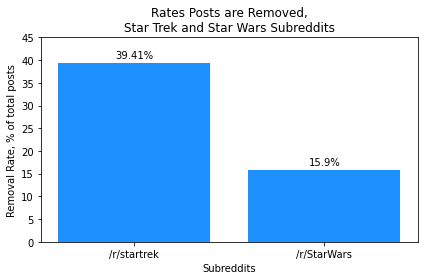

In [204]:
removal_rates = {
    'Star Trek': round((counts[0]/len(df[df["subreddit"] == "startrek"]))*100, 2),
    'Star Wars': round((counts[1]/len(df[df["subreddit"] == "starwars"]))*100, 2)
}
plt.title('Rates Posts are Removed,\nStar Trek and Star Wars Subreddits')
plt.xlabel('Subreddits')
plt.ylabel('Removal Rate, % of total posts')

plt.ylim(0, 45)
plt.bar(['/r/startrek', '/r/StarWars'], removal_rates.values(), color = 'dodgerblue')

plt.text(0, removal_rates['Star Trek']+1, str(removal_rates['Star Trek'])+'%', ha = 'center')
plt.text(1, removal_rates['Star Wars']+1, str(removal_rates['Star Wars'])+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/removal_rates.png');

In [205]:
#I referenced NLP 1 Lesson 5.01 to find the list of English stopwords - THIS DOESN'T SEEM TO BE THE SAME LIST AS THE ONE IN SKLEARN
print(sorted((stopwords).words('english')))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

These are the words I'm removing from the stopwords list so I can see if they appear in the titles of removed posts: 'against', 'ain', 'am', 'and', 'are', 'aren', "aren't", 'be', 'been', 'being', 'but', 'can', 'couldn', 'did', 'didn', "didn't", 'do', 'does', 'doesn',"couldn't", "doesn't", 'doing', 'don', "don't", 'down', 'few', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having','he', 'her', 'hers', 'herself', 'him', 'himself', 'his','is', 'isn', "isn't", 'just',  'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'needn', "needn't", 'no', 'nor', 'not', 'off', 'on', 'only', 'or', 'out', 'over', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'should',  'so', 'some', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn', "wasn't", 'were', 'weren', "weren't", 'will', 'won', "won't", 'wouldn', "wouldn't",

I've kept all verbs in the titles (i.e. taken them out of the stopwords list). For example, I kept 'is' because I want to keep contractions like "isn't", which is not value neutral. While it seems more likely 'is' will appear in a value neutral statement, that seems to be tilting the playing field if I remove it.

I also opted to remove gendered pronouns from the stopwords list. I'm curious to see if there are any patterns to the use of gendered pronouns.

In [206]:
neutral_stopwords = ['a', 'about', 'above', 'after', 'again', 'all', 'an', 'any', 'as', 'at', 'because', 'before', 'below',
                     'between', 'both', 'by', 'd', 'during', 'each', 'for', 'from',  'here',  'how', 'i', 'if', 'in', 'into', 'it', "it's", 'its', 'itself',
                     'll', 'm', 'ma', 'me','my', 'myself', 'now', 'o', 'of', 'once', 'other', 'our', 'ours', 'ourselves', 
                     'own', 're', 's',   'such', 't', 'than', 'that', "that'll", 'the', 'their',
                     'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 
                      've', 'we', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
                     'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

I referenced the NLP Lab 5.02 on EDA for help with getting the following code right.

In [207]:
#EXAMINING REMOVED VERSUS NOT REMOVED - ENGLISH STOP WORDS
cvec = CountVectorizer(stop_words = neutral_stopwords)
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df_copy['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING ALL POSTS')
print('')

top_10_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts {[word for word in top_10_removed if word not in top_10_not_removed]}')
print('='*25)

top_25_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts {[word for word in top_25_removed if word not in top_25_not_removed]}')
print('='*25)

top_50_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed posts but not in the top 50 words for not-removed posts {[word for word in top_50_removed if word not in top_50_not_removed]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARTREK POSTS')
print('')

top_10_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "startrek"\n posts but not in the top 10 words for not-removed "startrek" posts {[word for word in top_10_removed_st if word not in top_10_not_removed_st]}')
print('='*25)

top_25_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "startrek"\n posts but not in the top 25 words for not-removed "startrek" posts {[word for word in top_25_removed_st if word not in top_25_not_removed_st]}')
print('='*25)

top_50_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for not-removed "startrek" posts {[word for word in top_50_removed_st if word not in top_50_not_removed_st]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARWARS POSTS')
print('')

top_10_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "StarWars"\n posts but not in the top 10 words for not-removed "StarWars" posts {[word for word in top_10_removed_sw if word not in top_10_not_removed_sw]}')
print('='*20)

top_25_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "StarWars"\n posts but not in the top 25 words for not-removed "StarWars" posts {[word for word in top_25_removed_sw if word not in top_25_not_removed_sw]}')
print('='*20)

top_50_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for not-removed "StarWars" posts {[word for word in top_50_removed_sw if word not in top_50_not_removed_sw]}')


Vectorized shape: (6946, 7908)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7908)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7910)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7910 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


EXAMINING ALL POSTS

The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts ['picard']
The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts ['snw', 'so', 'spo

In [208]:
cvec = CountVectorizer(stop_words = neutral_stopwords)
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df_copy['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('TOP WORDS')
print('')
print('')
print('='*25)
print('')
print('')


top_10_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])


print('Top 10, all posts:', top_10_all)
print('='*20)
print('Top 25, all posts:', top_25_all)
print('='*20)
print('Top 50, all posts:', top_50_all)
print('='*25)
print('')

print('Top 10, all Star Trek posts:', top_10_all_st)
print('='*20)
print('Top 25, all Star Trek posts:', top_25_all_st)
print('='*20)
print('Top 50, all Star Trek posts:', top_50_all_st)
print('='*25)
print('')

print('Top 10, all Star Wars posts:', top_10_all_sw)
print('='*20)
print('Top 25, all Star Wars posts:', top_25_all_sw)
print('='*20)
print('Top 50, all Star Wars posts:', top_50_all_sw)

Vectorized shape: (6946, 7908)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7908)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7910)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7910 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


TOP WORDS




Top 10, all posts: ['star', 'and', 'is', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'on']
Top 25, all posts: ['star', 'and', 'is', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'on', 'was', 'episode', 'picard', 'vader', 'strange', 'worlds', 'have', 'do', 'be', 'like', 'series', 

-----

# English Stopwords Removed
Exploring the removed posts with all 'english' stopwords removed.

In [210]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df_copy['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING ALL POSTS')
print('')

top_10_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts {[word for word in top_10_removed if word not in top_10_not_removed]}')
print('='*25)

top_25_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts {[word for word in top_25_removed if word not in top_25_not_removed]}')
print('='*25)

top_50_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] =='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed = list(pd.Series(with_removed_vectorized[with_removed_vectorized['selftext'] !='[removed]'].drop(columns = ['selftext', 'subreddit_name'])\
                           .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed posts but not in the top 50 words for not-removed posts {[word for word in top_50_removed if word not in top_50_not_removed]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARTREK POSTS')
print('')

top_10_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "startrek"\n posts but not in the top 10 words for not-removed "startrek" posts {[word for word in top_10_removed_st if word not in top_10_not_removed_st]}')
print('='*25)

top_25_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "startrek"\n posts but not in the top 25 words for not-removed "startrek" posts {[word for word in top_25_removed_st if word not in top_25_not_removed_st]}')
print('='*25)

top_50_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_st = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'startrek')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "startrek" posts but not in the top 50 words for not-removed "startrek" posts {[word for word in top_50_removed_st if word not in top_50_not_removed_st]}')

print('')
print('')
print('*'*25)
print('')
print('')
print('EXAMINING STARWARS POSTS')
print('')

top_10_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])
top_10_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:10]['index'])

print(f'The following words appear in the top 10 most used words in removed "StarWars"\n posts but not in the top 10 words for not-removed "StarWars" posts {[word for word in top_10_removed_sw if word not in top_10_not_removed_sw]}')
print('='*20)

top_25_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])
top_25_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                         .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:25]['index'])

print(f'The following words appear in the top 25 most used words in removed "StarWars"\n posts but not in the top 25 words for not-removed "StarWars" posts {[word for word in top_25_removed_sw if word not in top_25_not_removed_sw]}')
print('='*20)

top_50_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] =='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])
top_50_not_removed_sw = list(pd.Series(with_removed_vectorized[(with_removed_vectorized['selftext'] !='[removed]') & (with_removed_vectorized['subreddit_name'] == 'starwars')]\
                                   .drop(columns = ['selftext', 'subreddit_name']).sum().sort_values(ascending = False)).reset_index()[:50]['index'])

print(f'The following words appear in the top 50 most used words in removed "StarWars" posts but not in the top 50 words for not-removed "StarWars" posts {[word for word in top_50_removed_sw if word not in top_50_not_removed_sw]}')


Vectorized shape: (6946, 7719)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7719)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7721)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7721 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


EXAMINING ALL POSTS

The following words appear in the top 10 most used words in removed posts but not in the top 10 words for not-removed posts ['strange', 'worlds']
The following words appear in the top 25 most used words in removed posts but not in the top 25 words for not-removed posts ['quest

In [211]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df['title'])
vectorized = cvec.transform(df['title'])
print('Vectorized shape:', vectorized.shape)
print('Vectorized type:', type(vectorized))
print('='*25)

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape:', vectorized.shape)
print('Vectorized dataframe type:', type(vectorized))
print('='*25)

with_removed_vectorized = pd.concat([df['selftext'], df_copy['subreddit_name'], vectorized], axis = 1)
print('Vectorized dataframe with text and subreddit labels, shape:', with_removed_vectorized.shape)
print(with_removed_vectorized.head(1))
print("="*25)

print('Number of removed posts in new dataframe:', len(with_removed_vectorized[with_removed_vectorized["selftext"] == "[removed]"]))
print('Sanity check. Number of removed posts from original dataframe:', len(df[df["selftext"] == "[removed]"]))

print('')
print('')
print('*'*25)
print('')
print('')
print('TOP WORDS')
print('')
print('')
print('='*25)
print('')
print('')

top_10_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all = list(pd.Series(with_removed_vectorized.drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_st = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'startrek'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])

top_10_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:10]['index'])

top_25_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:25]['index'])

top_50_all_sw = list(pd.Series(with_removed_vectorized[with_removed_vectorized['subreddit_name'] == 'starwars'].drop(columns = ['selftext', 'subreddit_name'])\
                       .sum().sort_values(ascending = False)).reset_index()[:50]['index'])


print('Top 10, all posts:', top_10_all)
print('='*20)
print('Top 25, all posts:', top_25_all)
print('='*20)
print('Top 50, all posts:', top_50_all)
print('='*25)
print('')

print('Top 10, all Star Trek posts:', top_10_all_st)
print('='*20)
print('Top 25, all Star Trek posts:', top_25_all_st)
print('='*20)
print('Top 50, all Star Trek posts:', top_50_all_st)
print('='*25)
print('')

print('Top 10, all Star Wars posts:', top_10_all_sw)
print('='*20)
print('Top 25, all Star Wars posts:', top_25_all_sw)
print('='*20)
print('Top 50, all Star Wars posts:', top_50_all_sw)

Vectorized shape: (6946, 7719)
Vectorized type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorized dataframe shape: (6946, 7719)
Vectorized dataframe type: <class 'pandas.core.frame.DataFrame'>
Vectorized dataframe with text and subreddit labels, shape: (6946, 7721)
    selftext subreddit_name  00  000  01  010  01x06  02  02png  03  ...  \
0  [removed]       startrek   0    0   0    0      0   0      0   0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 7721 columns]
Number of removed posts in new dataframe: 1936
Sanity check. Number of removed posts from original dataframe: 1936


*************************


TOP WORDS




Top 10, all posts: ['star', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'episode', 'picard', 'vader']
Top 25, all posts: ['star', 'trek', 'new', 'obi', 'kenobi', 'wan', 'wars', 'episode', 'picard', 'vader', 'strange', 'worlds', 'like', 'series', 'season', 'snw', 'did', 'just', 'sp

# Comparing Blank Submissions Across the Subreddits

Does either subreddit have a higher rate of blank submissions? For the purposes of this I'm removing the 'removed' and 'deleted' posts.

In [212]:
print('Value counts by subreddit:\n',df['subreddit'].value_counts())
print('')
print('Value counts of blank posts by subreddit:\n',df[df['selftext'] == '']['subreddit'].value_counts())

blank_values = df[df['selftext'] == '']['subreddit'].value_counts().tolist()
blank_keys = df[df['selftext'] == '']['subreddit'].value_counts().keys().tolist()
print('')
print('Blank Keys:', blank_keys)

sw_percent_blank = blank_values[0]/len(df[df['subreddit'] == 'starwars'])*100
st_percent_blank = blank_values[1]/len(df[df['subreddit'] == 'startrek'])*100
print(' ')
print('*'*25)
print('Star Wars percent blank submissions:', sw_percent_blank)
print('='*20)
print('Star Trek percent blank submissions:', st_percent_blank)

Value counts by subreddit:
 startrek    3537
starwars    3409
Name: subreddit, dtype: int64

Value counts of blank posts by subreddit:
 starwars    1729
startrek     630
Name: subreddit, dtype: int64

Blank Keys: ['starwars', 'startrek']
 
*************************
Star Wars percent blank submissions: 50.71868583162218
Star Trek percent blank submissions: 17.8117048346056


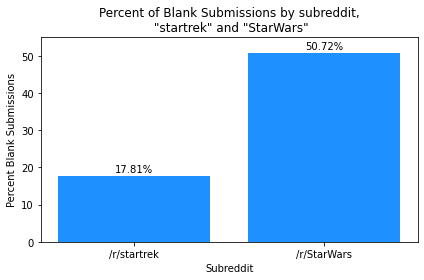

In [213]:
plt.title('Percent of Blank Submissions by subreddit,\n "startrek" and "StarWars"')
plt.xlabel('Subreddit')
plt.ylabel('Percent Blank Submissions')
plt.ylim(0,55)
plt.bar(['/r/startrek', '/r/StarWars'], [st_percent_blank, sw_percent_blank], color = 'dodgerblue')

plt.text(1, sw_percent_blank+1, str(round(sw_percent_blank, 2))+'%', ha = 'center')
plt.text(0, st_percent_blank+1, str(round(st_percent_blank, 2))+'%', ha = 'center')

plt.tight_layout()
plt.savefig('images/percent_blank_posts.png');


Because of the high percentage of blank posts, consisting just of a title, in the StarWars subreddit, I'm going to include the titles in my model building. It seems to be an important part of how StarWars subredditors communicate with each other.

# Exploring Post Length and Number of Words In Non-Removed or Deleted Submission Posts

There are a lot of blank submissions. There are 6 '[deleted]' submissions, as well. '[deleted]' means that [the user deleted the post](https://www.reddit.com/r/help/comments/h92oqg/what_does_deleted_mean/).

For the purposes of examining word counts in these submissions, I've removed the empty and '[deleted]' submissions.

In [214]:
no_remov_del_subm = df[(df['selftext'] != '[removed]') & (df['selftext'] != '[deleted]')]
print(no_remov_del_subm['selftext'].value_counts()[:5])
print(no_remov_del_subm.shape)
no_remov_del_subm.head(2)

,created_utc,selftext,subreddit,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0,0,72,12


In preparation for vectorizing I changed the 'subreddit' column name to 'subreddit_name'.

In [215]:
no_remov_del_subm = no_remov_del_subm.rename(columns = {'subreddit': 'subreddit_name'})
no_remov_del_subm.head(1)

,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22


In [216]:
print(f'Submission length (characters) mean by subreddit is {no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].mean()}')
print(f'Submission length (characters median by subreddit is {no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].median()}')

Submission length (characters) mean by subreddit is subreddit_name
startrek    459.099486
starwars    243.629190
Name: submission_length, dtype: float64
Submission length (characters median by subreddit is subreddit_name
startrek    185.0
starwars      0.0
Name: submission_length, dtype: float64


I referred to the [matplotplib documentation](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html) to create the below subplot. Very helpful. [This post](https://stackoverflow.com/a/15858264) helped me see how to adjust the ylim for subplots. [This documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html) showed me how to shift the title up a little so it wouldn't be so close to the subplot labels.

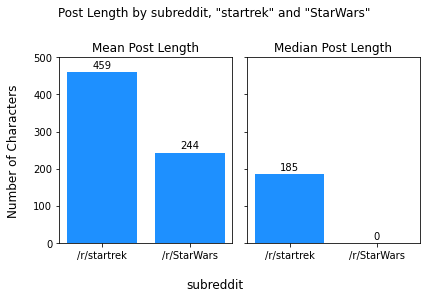

In [217]:
subm_mean_len = no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].mean().tolist()
subm_median_len = no_remov_del_subm.groupby(["subreddit_name"])["submission_length"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Length by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_mean_len[0], subm_mean_len[1]], color = 'dodgerblue')
ax1.set_title('Mean Post Length')
ax1.set_ylim(0,500)
ax1.text(0, subm_mean_len[0]+10, round(subm_mean_len[0]), ha = 'center')
ax1.text(1, subm_mean_len[1]+10, round(subm_mean_len[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_median_len[0], subm_median_len[1]], color = 'dodgerblue')
ax2.set_title('Median Post Length')
ax2.text(0, subm_median_len[0]+10, round(subm_median_len[0]), ha = 'center')
ax2.text(1, subm_median_len[1]+10, round(subm_median_len[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_length.png');

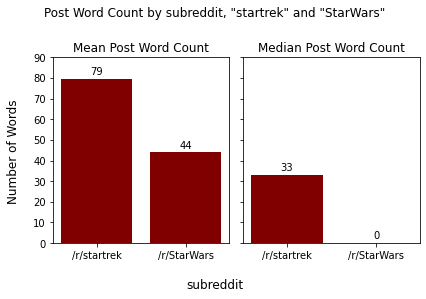

In [218]:
subm_word_count_mean = no_remov_del_subm.groupby(["subreddit_name"])["submission_word_count"].mean().tolist()
subm_word_count_median = no_remov_del_subm.groupby(["subreddit_name"])["submission_word_count"].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Post Word Count by subreddit, "startrek" and "StarWars"', y = 1)
fig.supylabel('Number of Words')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_mean[0], subm_word_count_mean[1]], color = 'maroon')
ax1.set_title('Mean Post Word Count')
ax1.set_ylim(0,90)
ax1.text(0, subm_word_count_mean[0]+2, round(subm_word_count_mean[0]), ha = 'center')
ax1.text(1, subm_word_count_mean[1]+2, round(subm_word_count_mean[1]), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [subm_word_count_median[0], subm_word_count_median[1]], color = 'maroon')
ax2.set_title('Median Post Word Count')
ax2.text(0, subm_word_count_median[0]+2, round(subm_word_count_median[0]), ha = 'center')
ax2.text(1, subm_word_count_median[1]+2, round(subm_word_count_median[1]), ha = 'center')

plt.tight_layout()
plt.savefig('images/post_word_count.png');

-----

# Exploring Word Length in Posts

I may be able to determine a precise word length average once I've vectorized, though I suspect that will take a really long time to do (and may not happen as a result.) The x factor is how many blank spaces there are in a given post. My rough approach assumes one blank space per word, which is a rough estimate because that's not necessarily true. But it gives us a relatively quick estimate of word length.

In [219]:
only_text = no_remov_del_subm[no_remov_del_subm['selftext'] != '']
only_text['rough_avg_word_length'] = (only_text['submission_length']-only_text['submission_word_count'])/only_text['submission_word_count']
only_text.head()

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_34226/3405056248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_text['rough_avg_word_length'] = (only_text['submission_length']-only_text['submission_word_count'])/only_text['submission_word_count']


,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count,rough_avg_word_length
2026,1656257863,Now that I’ve moved to a bigger place the time has come to display the Enterprise and her crew! I’m so happy with how it looks! Engage!\n\n[images of bridge](https://imgur.com/a/yRZaV0f),startrek,Had the TNG Bridge Playset packed away for too long!,184,30,52,10,5.133333
2027,1656255805,Is that just a fun nod for people paying attention or was Benny meant to be a real person and not just in Sisko's mind?,startrek,Benny Russell wrote M'Benga's book?,119,25,35,5,3.760000
2028,1656255728,Just wondering where you can stream the new Star Trek shows in Canada? I know Paramount plus has the the old ones.,startrek,Streaming the new Star term shows?,114,22,34,6,4.181818
2029,1656254381,"Just interested in hearing some cool ideas. I’d love to see the OG crew take on the Borg but I’m curious how it could differentiate itself from the other recent takes on them that we’ve seen.\n\nI’m also curious as to whether or not the crew is still on their five-year mission, and what justification would be used to bring them back into space. Do we get retired Admiral Kirk? Sulu on the Excel...",startrek,What are your pitches for Star Trek Kelvin 4?,487,90,45,9,4.411111
2030,1656253203,I was watching the new episode of SNW and it just hit me that Ortagus wears red rather than gold. And I was wondering if anyone knew why?,startrek,Why Does Ortagus Wear Red? SNW,137,28,30,6,3.892857


In [220]:
only_text.groupby('subreddit_name')['rough_avg_word_length'].mean()

subreddit_name
startrek    5.441365
starwars    4.821179
Name: rough_avg_word_length, dtype: float64

In [221]:
only_text.groupby('subreddit_name')['rough_avg_word_length'].median()

subreddit_name
startrek    4.563636
starwars    4.418605
Name: rough_avg_word_length, dtype: float64

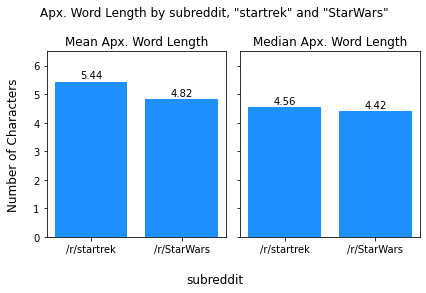

In [222]:
mean_word_length = only_text.groupby('subreddit_name')['rough_avg_word_length'].mean().tolist()
median_word_length = only_text.groupby('subreddit_name')['rough_avg_word_length'].median().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
fig.suptitle('Apx. Word Length by subreddit, "startrek" and "StarWars"')
fig.supylabel('Number of Characters')
fig.supxlabel('subreddit')

ax1.bar(['/r/startrek', '/r/StarWars'], [mean_word_length[0], mean_word_length[1]], color = 'dodgerblue')
ax1.set_title('Mean Apx. Word Length')
ax1.set_ylim(0,6.5)
ax1.text(0, mean_word_length[0]+.1, round(mean_word_length[0], 2), ha = 'center')
ax1.text(1, mean_word_length[1]+.1, round(mean_word_length[1], 2), ha = 'center')

ax2.bar(['/r/startrek', '/r/StarWars'], [median_word_length[0], median_word_length[1]], color = 'dodgerblue')
ax2.set_title('Median Apx. Word Length')
ax2.text(0, median_word_length[0]+.1, round(median_word_length[0], 2), ha = 'center')
ax2.text(1, median_word_length[1]+.1, round(median_word_length[1], 2), ha = 'center')

plt.tight_layout()
plt.savefig('images/word_lengths.png');

-----

# Exploring most Common Words in Submissions (Posts) and Titles
Because so much communication on the Star Wars subreddit occurs in titles, I've combined the two and analyzed the frequency of words.

Initially, I tried this with the 'neutral' stopwords, but there are too many of the other stop words appearing, so I've eliminated all English stopwords.

I'm continuing to work with the dataframe that has had `'[removed]'` and `'[deleted]'` 'selftext' removed.

In [223]:
no_remov_del_subm.head()

,created_utc,selftext,subreddit_name,title,submission_length,submission_word_count,title_length,title_word_count
1394,1656243979,,startrek,I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.,0,0,119,22
1395,1656242414,,startrek,"America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.",0,0,72,12
1396,1656224204,,startrek,Analysis: Star Trek: The Next Generation’ Guest Stars Most Likely To Appear In ‘Picard’ Season 3,0,0,96,16
1397,1656207850,,startrek,"One of the first occasions in which the word ""hell"" was used as profanity on television.",0,0,88,16
1398,1656195635,,startrek,Is A TOS Reboot Coming Soon?,0,0,28,6


In [239]:
all_blanks_and_text = no_remov_del_subm.copy()
all_blanks_and_text['all_words']= no_remov_del_subm['selftext']+' '+ no_remov_del_subm['title']
all_blanks_and_text = all_blanks_and_text[['subreddit_name', 'all_words']]
print('Head for new dataframe:\n', all_blanks_and_text.head(1))
print('')
print('Shape for new dataframe', all_blanks_and_text.shape)
print(' ')

cvec = CountVectorizer(stop_words = 'english')
cvec.fit(all_blanks_and_text['all_words'])
vectorized = cvec.transform(all_blanks_and_text['all_words'])
print('Shape for vectorized',vectorized.shape)
print(' ')


vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Shape for vectorized dataframe:', vectorized.shape)
print('Confirming the type is dataframe', type(vectorized))
print('')
print('Checking the new dataframe head\n',vectorized.head())

Head for new dataframe:
      subreddit_name  \
1394       startrek   

                                                                                                                     all_words  
1394   I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.  

Shape for new dataframe (5005, 2)
 
Shape for vectorized (5005, 17719)
 
Shape for vectorized dataframe: (5005, 17719)
Confirming the type is dataframe <class 'pandas.core.frame.DataFrame'>

Checking the new dataframe head
    00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  02  021  ...  \
0   0    0    0                0   0    0             0      0   0    0  ...   
1   0    0    0                0   0    0             0      0   0    0  ...   
2   0    0    0                0   0    0             0      0   0    0  ...   
3   0    0    0                0   0    0             0      0   0    0  ...   
4   0    0    0                0   0    0    

Initially, I was getting too many rows. Reading [this](https://stackoverflow.com/a/55726005) made it clear it was because of residual indexes, so I reset the indexes. Initially, I got some weird additional columns, so I played with it


In [240]:
subreddit_names = pd.DataFrame()
subreddit_names['subreddit_name'] = all_blanks_and_text['subreddit_name']
subreddit_names = subreddit_names.reset_index()

all_words_df = pd.concat([subreddit_names, vectorized], axis = 1)
all_words_df = all_words_df.drop(columns = 'index')
print('Shape for dataframe after adding in "subreddit name":', all_words_df.shape)
print('Checking head of new dataframe:\n',all_words_df.head())
print(' ')
print('*'*25)
print('')

print(f'The top 10 words in all these posts are:\n{all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Trek posts are:\n{all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Wars posts are:\n{all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')


Shape for dataframe after adding in "subreddit name": (5005, 17719)
Checking head of new dataframe:
   subreddit_name  00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  \
0       startrek   0    0    0                0   0    0             0      0   
1       startrek   0    0    0                0   0    0             0      0   
2       startrek   0    0    0                0   0    0             0      0   
3       startrek   0    0    0                0   0    0             0      0   
4       startrek   0    0    0                0   0    0             0      0   

   02  ...  ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0   0  ...     0      0    0      0   0    0   0   0      0   0  
1   0  ...     0      0    0      0   0    0   0   0      0   0  
2   0  ...     0      0    0      0   0    0   0   0      0   0  
3   0  ...     0      0    0      0   0    0   0   0      0   0  
4   0  ...     0      0    0      0   0    0   0   0      0   0  

[5 rows x 17719

[This stackoverflow answer](https://stackoverflow.com/a/52461208) showed me how to set the xtick label rotation in a subplot.

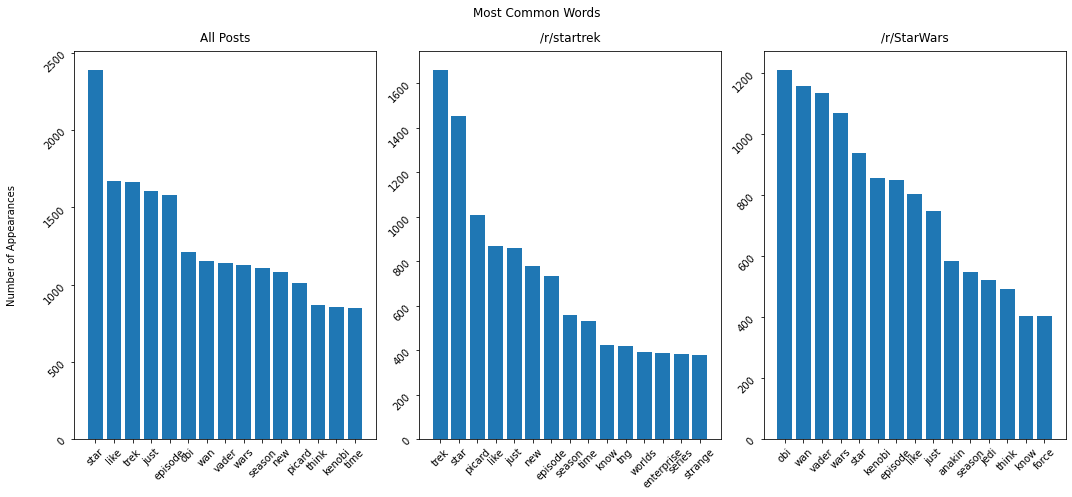

In [241]:
allkeys = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
allvalues = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

stkeys = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
stvalues = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

swkeys = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
swvalues = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7)) #not setting sharey the same because the number of each is a different scale

fig.suptitle('Most Common Words')

ax1.bar(allkeys, allvalues)
ax1.tick_params(rotation = 45)
ax1.set_title('All Posts', pad = 10)
ax1.set_ylabel('Number of Appearances', labelpad = 25)

ax2.bar(stkeys, stvalues)
ax2.tick_params(rotation = 45)
ax2.set_title('/r/startrek', pad = 10)

ax3.bar(swkeys, swvalues)
ax3.tick_params(rotation = 45)
ax3.set_title('/r/StarWars', pad = 10)

plt.tight_layout()
plt.savefig('images/commonwords1.png');

-----

# Exploring Word Counts in Non-Removed Submission Posts with Proper Names Removed

I used the dataframe that I developed that combines titles and text into a single column for analysis. Now, though, I'm going to remove proper names I found were used frequently by adding to the stopwords. I opted to look at the top 50 words from the dataframe as a whole, among /r/startrek elements, and among /r/StarWars elements. I created a set with these words and selected the proper names by hand. 

There are a few choices that were subjective:

This includes removing "star" (most frequent word), "trek", and "wars" because they appear so frequently and are from the titles of these franchises. Also: 'force' (The Force). I also removed 'strange' because it's in the title of 'strange new worlds', though I've left in 'new' and 'worlds', which is a debatable decision. I've left 'order' in (i.e. not included it in my new stop words), though that may be a reference to the 'Sith Order' in Star Wars. 'captain' is another word I've left, though it's worth noting that is a very 'Star Trek' word, as almost every episode/show/movie has a captain, which is not true of Star Wars.

This [stackoverflow answer](https://stackoverflow.com/a/24386751) showed me how to combine the 'english' stopwords with my proper name stopwords.

Ultimately, I'm glad to have done this analysis, but I don't find what's left particularly revelatory. In terms of learning about the subreddits from the perspective of the most commonly used words, it seems to me that there's more to be gleaned (and more fun to be had) by seeing which characters, shows, etc., that show up versus the fairly banal list of words (and even abbreviations) that appear in the words that appear at the top of the lists when the proper names are removed.

In [235]:
top_50 = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, all posts', top_50)
print(' ')
top_50_st = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, Star Trek subreddit', top_50_st)
print(' ')
top_50_sw = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(50).keys().tolist()
print('Top 50 words, Star Wars subreddit', top_50_sw)
print('')

combined_top_set = set(top_50+top_50_st+top_50_sw)
print('Set of words that appear in these three top 50s', combined_top_set)

Top 50 words, all posts ['star', 'like', 'trek', 'just', 'episode', 'obi', 'wan', 'vader', 'wars', 'season', 'new', 'picard', 'think', 'kenobi', 'time', 'know', 'series', 'really', 'did', 've', 'don', 'anakin', 'people', 'jedi', 'does', 'good', 'way', 'watch', 'amp', 'force', 'character', 'tng', 'love', 'make', 'episodes', 'worlds', 'luke', 'watching', 'strange', 'feel', 'enterprise', 'story', 'ship', 'want', 'borg', 'https', 'years', 'best', 'order', 'didn']
 
Top 50 words, Star Trek subreddit ['trek', 'star', 'picard', 'like', 'just', 'new', 'episode', 'season', 'time', 'know', 'tng', 'worlds', 'enterprise', 'series', 'strange', 'think', 'borg', 've', 'really', 'don', 'ship', 'snw', 'did', 'episodes', 'people', 'discovery', 'does', 'good', 'https', 'captain', 'watch', 'way', 'crew', 'love', 'tos', 'watching', 'ds9', 'years', 'com', 'spock', 'amp', 'voyager', 'make', 'best', 'starfleet', 'characters', 'federation', 'timeline', 'character', 'seen']
 
Top 50 words, Star Wars subreddit [

In [236]:
#proper_names = ['star', 'trek', 'obi', 'wan', 'vader', 'wars', 'picard', 'kenobi', 'anakin', 'jedi', 'force', 'tng', 'luke', 'strange', 'enterprise', 'borg']

proper_names = ['snw', 'discovery', 'force', 'federation', 'darth', 'borg', 'wars', 'anakin',\
                'lightsaber', 'vader', 'picard', 'skywalker', 'sith', 'spock', 'starfleet', 'leia',\
                'star', 'tng', 'ds9', 'reva', 'strange', 'luke', 'series', 'obi', 'clone', 'trek',\
                'enterprise', 'disney', 'wan', 'voyager', 'jedi', 'kenobi', 'tos']

stop_words = text.ENGLISH_STOP_WORDS.union(proper_names)

all_blanks_and_text = no_remov_del_subm.copy()
all_blanks_and_text['all_words']= no_remov_del_subm['selftext']+' '+ no_remov_del_subm['title']
all_blanks_and_text = all_blanks_and_text[['subreddit_name', 'all_words']]
all_blanks_and_text.head()

print('Dataframe shape before vectorization:', all_blanks_and_text.shape)
print('')

cvec = CountVectorizer(stop_words = stop_words)
cvec.fit(all_blanks_and_text['all_words'])
vectorized = cvec.transform(all_blanks_and_text['all_words'])
print('Vectorized shape:', vectorized.shape)
print('')

vectorized = pd.DataFrame(vectorized.todense(), columns = cvec.get_feature_names_out())
print('Vectorized dataframe shape',vectorized.shape)
print("Confirming its type is dataframe:", type(vectorized))
print("Head of vectorized dataframe:\n",vectorized.head(1))
print('')

subreddit_names = pd.DataFrame()
subreddit_names['subreddit_name'] = all_blanks_and_text['subreddit_name']
subreddit_names = subreddit_names.reset_index()

all_words_df = pd.concat([subreddit_names, vectorized], axis = 1)
all_words_df = all_words_df.drop(columns = 'index')
print("Shape of dataframe with subbreddit names restored:", all_words_df.shape)
print("Head of dataframe with subbreddit names restored:\n", all_words_df.head(1))

print('')
print('*'*25)

print(f'The top 10 words in all these posts are:\n{all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Trek posts are:\n{all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')
print(f'The top 10 words in all Star Wars posts are:\n{all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False)[:10]}')


Dataframe shape before vectorization: (5005, 2)

Vectorized shape: (5005, 17686)

Vectorized dataframe shape (5005, 17686)
Confirming its type is dataframe: <class 'pandas.core.frame.DataFrame'>
Head of vectorized dataframe:
    00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  02  021  ...  \
0   0    0    0                0   0    0             0      0   0    0  ...   

   ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0     0      0    0      0   0    0   0   0      0   0  

[1 rows x 17686 columns]

Shape of dataframe with subbreddit names restored: (5005, 17686)
Head of dataframe with subbreddit names restored:
   subreddit_name  00  000  001  006225_8c6a1dd3  01  010  01414tqwn0t0  01x06  \
0       startrek   0    0    0                0   0    0             0      0   

   02  ...  ليلة  مهذبة  نسخ  وليلة  एक  लचस  षक  ดท  ทางเข  าส  
0   0  ...     0      0    0      0   0    0   0   0      0   0  

[1 rows x 17686 columns]

*************************
The top 

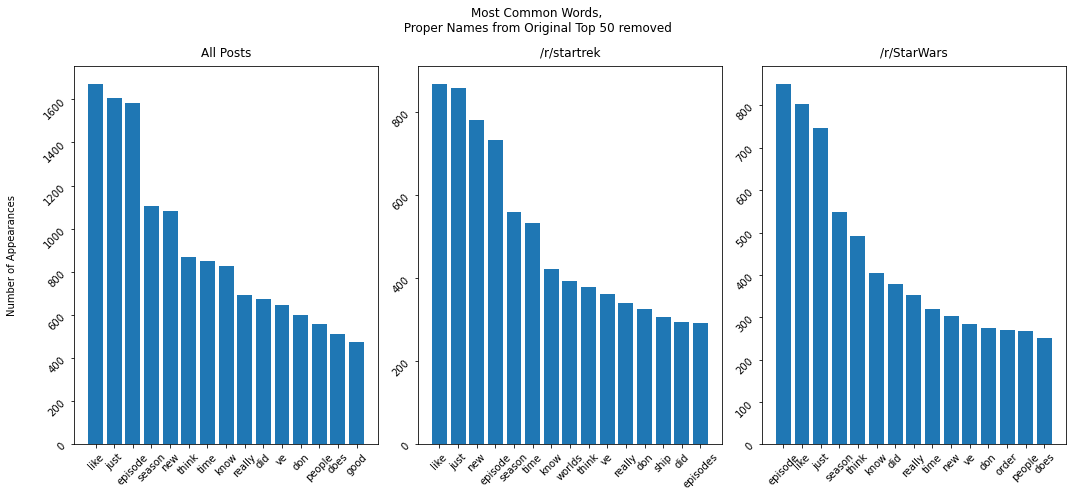

In [237]:
allkeys = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
allvalues = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

stkeys = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
stvalues = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

swkeys = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).keys().tolist()
swvalues = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(15).tolist()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,7)) #not setting sharey the same because the number of each is a different scale

fig.suptitle('Most Common Words,\n Proper Names from Original Top 50 removed')

ax1.bar(allkeys, allvalues)
ax1.tick_params(rotation = 45)
ax1.set_title('All Posts', pad = 10)
ax1.set_ylabel('Number of Appearances', labelpad = 25)

ax2.bar(stkeys, stvalues)
ax2.tick_params(rotation = 45)
ax2.set_title('/r/startrek', pad = 10)

ax3.bar(swkeys, swvalues)
ax3.tick_params(rotation = 45)
ax3.set_title('/r/StarWars', pad = 10)

plt.tight_layout()
plt.savefig('images/commonwords2.png');

-----

# Exporting the dataframe I want to work from for modeling

In [184]:
print(all_blanks_and_text.head())
all_blanks_and_text.shape

     subreddit_name  \
1394       startrek   
1395       startrek   
1396       startrek   
1397       startrek   
1398       startrek   

                                                                                                                     all_words  
1394   I’m beaming and I had to share - Sir Patrick Stewart answered my fan question on stage! An unforgettable moment for me.  
1395                                                  America and the Star Trek Universe. Roe Vs Wade, LGBTQIA Rights, Racism.  
1396                          Analysis: Star Trek: The Next Generation’ Guest Stars Most Likely To Appear In ‘Picard’ Season 3  
1397                                  One of the first occasions in which the word "hell" was used as profanity on television.  
1398                                                                                              Is A TOS Reboot Coming Soon?  


(5005, 2)

In [190]:
if os.path.exists(f'data/cleaned_all_text{date.today()}.csv') == True:
    print('ERROR: This filename exists. Please choose a different filename. FILE WAS NOT SAVED.')
else:
    all_blanks_and_text.to_csv(f'data/cleaned_all_text{date.today()}.csv', index = False)

In [242]:
# below is a line that can be uncommented and used to create a new dataframe on the same date.
# It's set to create cleaned_all_text{TODAY'SDATE}-1.

# all_blanks_and_text.to_csv(f'data/cleaned_all_text{date.today()}-1.csv', index = False)

I wanted to make my modeling harder, so I'm expanding my proper names and really show specific items list to take to the model.

In [244]:
top_150 = all_words_df.drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, all posts', top_150)
print(' ')
top_150_st = all_words_df[all_words_df["subreddit_name"]=="startrek"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, Star Trek subreddit', top_150_st)
print(' ')
top_150_sw = all_words_df[all_words_df["subreddit_name"]=="starwars"].drop(columns = "subreddit_name").sum().sort_values(ascending = False).head(150).keys().tolist()
print('Top 150 words, Star Wars subreddit', top_150_sw)
print('')

combined_top_set_150 = set(top_150+top_150_st+top_150_sw)
print('Set of words that appear in these three top 150s', combined_top_set_150)

Top 150 words, all posts ['star', 'like', 'trek', 'just', 'episode', 'obi', 'wan', 'vader', 'wars', 'season', 'new', 'picard', 'think', 'kenobi', 'time', 'know', 'series', 'really', 'did', 've', 'don', 'anakin', 'people', 'jedi', 'does', 'good', 'way', 'watch', 'amp', 'force', 'character', 'tng', 'love', 'make', 'episodes', 'worlds', 'luke', 'watching', 'strange', 'feel', 'enterprise', 'story', 'ship', 'want', 'borg', 'https', 'years', 'best', 'order', 'didn', 'got', 'darth', 'characters', 'shows', 'seen', 'great', 'going', 'snw', 'lot', 'say', 'discovery', 'com', 'movies', 'end', 'scene', 'movie', 'clone', 'things', 'thought', 'old', 'captain', 'better', 'leia', 'maybe', 'life', 'thing', 'crew', 'hope', 'actually', 'universe', 'doesn', 'point', 'watched', 'canon', 'fan', 'right', 'tos', 'timeline', 'ds9', 'little', 'reva', 'look', 'spock', 'use', 'original', 'disney', 'space', 'question', 'let', 'tv', 'bad', 'long', 'voyager', 'future', 'different', 'finale', 'federation', 'starfleet'

In [245]:
expanded_proper_names = ['seven', 'clone', 'warp', 'borg', 'trilogy', 'contact', 'prequels', 'anakin', 'paramount', 'leia',\
                         'kirk', 'wan', 'jedi', 'kenobi', 'snw', 'wars', 'vader', 'order', 'skywalker', 'klingon', 'starfleet',\
                         'ds9', 'captain', 'maul', 'luke', 'obi', 'rebels', 'data', 'voyager', 'st', 'discovery', 'federation',\
                         'pike', 'picard', 'mandalorian', 'klingons', 'star', 'tng', 'reva', 'strange', 'disney', 'worf',\
                         'riker', 'empire', 'jurati', 'palpatine', 'yoda', 'force', 'darth', 'republic', 'lightsaber', 'sith',\
                         'spock', 'boba', 'fett', 'thought', 'inquisitor', 'trek', 'enterprise', 'tos']


expanded_stop_words = text.ENGLISH_STOP_WORDS.union(expanded_proper_names)